#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [14]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

Let's also get the word indexs (word to word-id)

In [15]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [16]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [19]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [20]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [21]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** </br>
- *output function*: since we want to predict whether the sentiment is positive or negative (i.e. a binary classification task), the right activation function to choose is the ***sigmoidal*** one. 
</br>
Indeed, the sigmoid returns a number in the interval between 0 and 1, that we can interpret as a probability along with the right choice of the loss function.
- *loss function*: the correct loss function is the ***binary cross-entropy***, that is one of the most suitable for a binary classification task.

In addition, the model seems to slighty overfit.

In [22]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          100000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [24]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 158s 799ms/step - loss: 0.6299 - accuracy: 0.6334 - val_loss: 0.5826 - val_accuracy: 0.7188
Epoch 2/10
196/196 [==============================] - 152s 776ms/step - loss: 0.3991 - accuracy: 0.8292 - val_loss: 0.3722 - val_accuracy: 0.8429
Epoch 3/10
196/196 [==============================] - 154s 785ms/step - loss: 0.2757 - accuracy: 0.8907 - val_loss: 0.3516 - val_accuracy: 0.8503
Epoch 4/10
196/196 [==============================] - 160s 815ms/step - loss: 0.2400 - accuracy: 0.9084 - val_loss: 0.4527 - val_accuracy: 0.7886
Epoch 5/10
196/196 [==============================] - 168s 860ms/step - loss: 0.2242 - accuracy: 0.9137 - val_loss: 0.3818 - val_accuracy: 0.8478
Epoch 6/10
196/196 [==============================] - 162s 826ms/step - loss: 0.1593 - accuracy: 0.9436 - val_loss: 0.4387 - val_accuracy: 0.8440
Epoch 7/10
196/196 [==============================] - 166s 850ms/step - loss: 0.1226 - accuracy: 0.9582 - val_loss: 0.4705 -

Print the values of accuracy and the loss , and evaluate the model on the test set

In [25]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')



391/391 - 26s - loss: 0.5748 - accuracy: 0.8351 - 26s/epoch - 66ms/step
accuracy: 83.51%


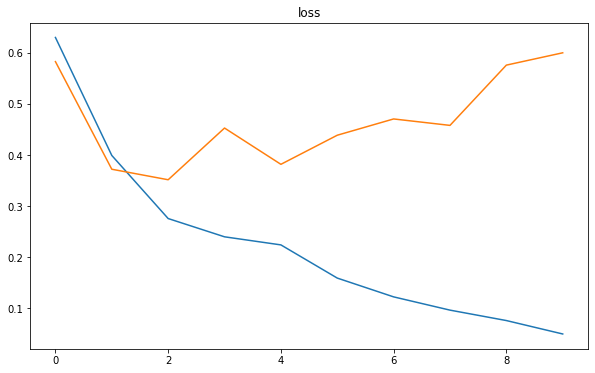

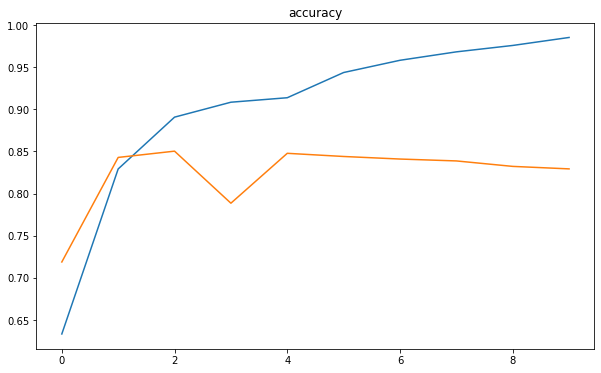

In [26]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 

In [ ]:
# -- LSTM model
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm (LSTM)                 (None, 16)                1728      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,745
Trainable params: 101,745
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 8s 22ms/step - loss: 0.5320 - accuracy: 0.7209 - val_loss: 0.3721 - val_accuracy: 0.8481
Epoch 2/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2883 - accuracy: 0.8912 - val_loss: 0.3557 - val_accuracy: 0.8460
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2219 - accuracy: 0.9214 - val_loss: 0.3074 - val_accuracy: 0.8733
Epoch 4/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1780 - accuracy: 0.9399 - val_loss: 0.3156 - val_accuracy: 0.8713
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1464 - accuracy: 0.9538 - val_loss: 0.3504 - val_accuracy: 0.8695
Epoch 6/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1377 - accuracy: 0.9548 - val_loss: 0.3743 - val_accuracy: 0.8392
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1163 - accuracy: 0.9641 - val_loss: 0.4730 - val_accuracy: 0.8562

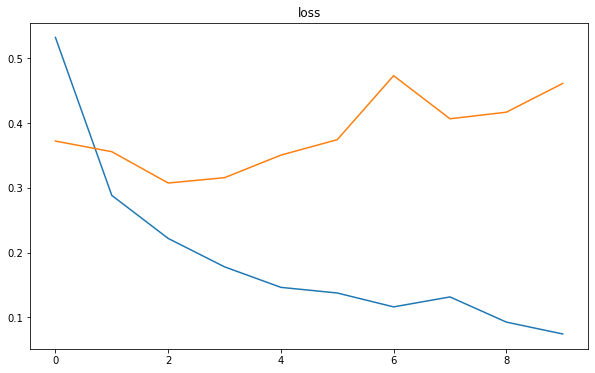

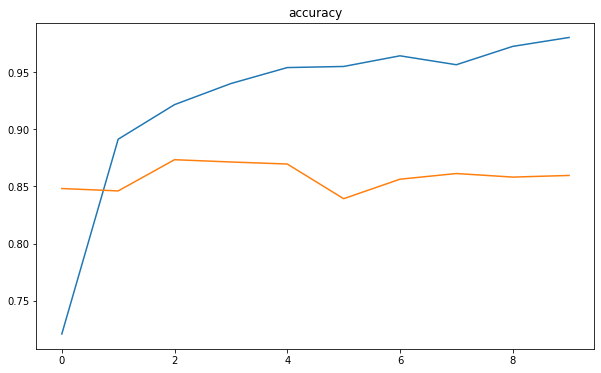

In [ ]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

# -- plot diagrams
plot_loss(history)

plot_accuracy(history)

# -- evalutate model 
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# -- GRU model 
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(18))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 18)                1620      
                                                                 
 dense_2 (Dense)             (None, 1)                 19        
                                                                 
Total params: 101,639
Trainable params: 101,639
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 0.5509 - accuracy: 0.7104 - val_loss: 0.3879 - val_accuracy: 0.8304
Epoch 2/10
196/196 [==============================] - 4s 20ms/step - loss: 0.3014 - accuracy: 0.8756 - val_loss: 0.3304 - val_accuracy: 0.8650
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2170 - accuracy: 0.9192 - val_loss: 0.3436 - val_accuracy: 0.8611
Epoch 4/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1856 - accuracy: 0.9313 - val_loss: 0.3839 - val_accuracy: 0.8514
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1621 - accuracy: 0.9430 - val_loss: 0.3750 - val_accuracy: 0.8560
Epoch 6/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1361 - accuracy: 0.9540 - val_loss: 0.4180 - val_accuracy: 0.8546
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1146 - accuracy: 0.9638 - val_loss: 0.4668 - val_accuracy: 0.8471

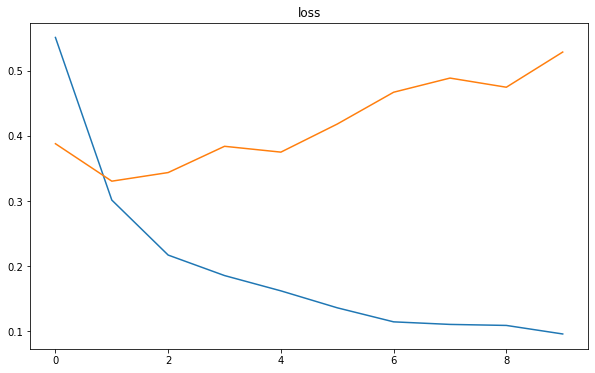

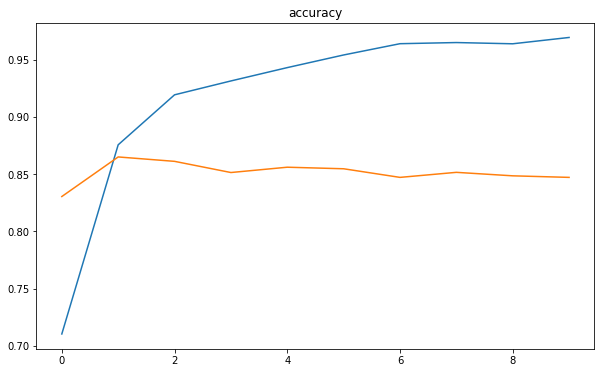

In [ ]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

# -- plot diagrams
plot_loss(history)

plot_accuracy(history)

# -- evalutate model 
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

**Answer**

**Performance**:

The performances I was able to achieve are:
- **SimpleRNN,** 32 units: **83.51 %**
- **LSTM,** 16 units: **85.99 %**
- **GRU,** 18 units: **85.18 %**

As we can see, the gated RNNs models are able to perform slightly better with respect to the simple RNN, due to the fact that they are efficient architectures capable of coping with the vanishing gradient effect. 

In particular, LSTM performs a bit better than GRU since the latter is a simplified version of it.

**Number of parameters**:

In order to keep more or less the same number of total parameters for all the three models, I set the number of units as described in the following:
- SimpleRNN: 32 units, 1376 parameters, 101,409 total parameters
- LSTM: 16 units, 1728 parameters, 101,745 total parameters
- GRU: 18 units, 1620 parameters, 101,639 total parameters

**Training time**

Finally, for what concerning the training time of the different models tested, I observed that the gated RNNs are way faster than the simple RNN, I guess because they have been design to be effective, efficient and specific architectures for recurrent networks, but at the same time it sounds weird to me that the gated RNNs are so much faster than a SimpleRNN (maybe the GPU runtime of Colab is not working correctly).

Furthermore, I noticed that GRU is slightly faster than LSTM, always by the fact they are a simplified version (but we need to take into account that actually, in the models I used, GRU has some less parameters).

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 15s 48ms/step - loss: 0.5316 - accuracy: 0.7342 - val_loss: 0.3690 - val_accuracy: 0.8402
Epoch 2/5
196/196 [==============================] - 7s 38ms/step - loss: 0.2795 - accuracy: 0.8902 - v

391/391 - 5s - loss: 0.3259 - accuracy: 0.8781 - 5s/epoch - 13ms/step
accuracy: 87.81%


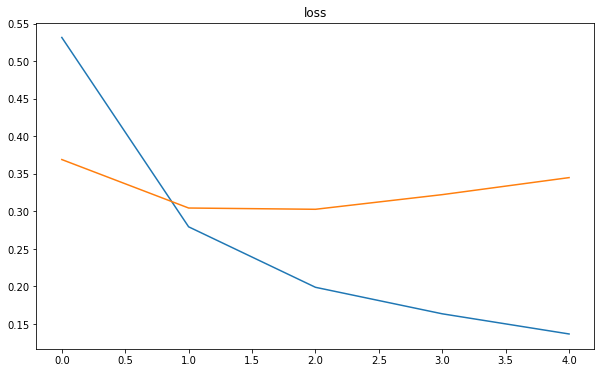

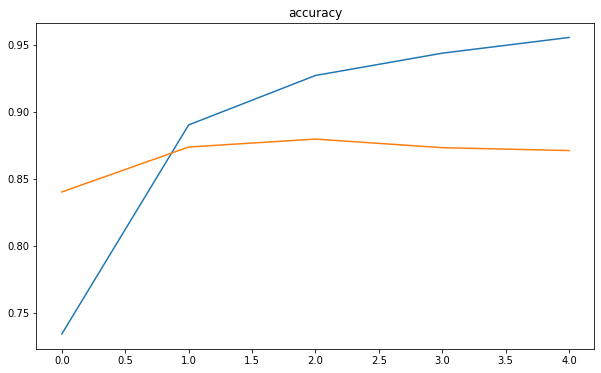

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [ ]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [ ]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [ ]:
embed_dim = 8  # Embedding size for each token
num_heads = 1  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/5
196/196 [==============================] - 4s 13ms/step - loss: 0.5871 - accuracy: 0.6812 - val_loss: 0.3338 - val_accuracy: 0.8570
Epoch 2/5
196/196 [==============================] - 2s 11ms/step - loss: 0.2857 - accuracy: 0.8864 - val_loss: 0.3152 - val_accuracy: 0.8640
Epoch 3/5
196/196 [==============================] - 2s 11ms/step - loss: 0.2142 - accuracy: 0.9206 - val_loss: 0.3248 - val_accuracy: 0.8664
Epoch 4/5
196/196 [==============================] - 2s 11ms/step - loss: 0.1676 - accuracy: 0.9415 - val_loss: 0.3597 - val_accuracy: 0.8609
Epoch 5/5
196/196 [==============================] - 2s 11ms/step - loss: 0.1436 - accuracy: 0.9530 - val_loss: 0.3906 - val_accuracy: 0.8614
391/391 - 1s - loss: 0.3861 - accuracy: 0.8627 - 1s/epoch - 3ms/step
accuracy: 86.27%


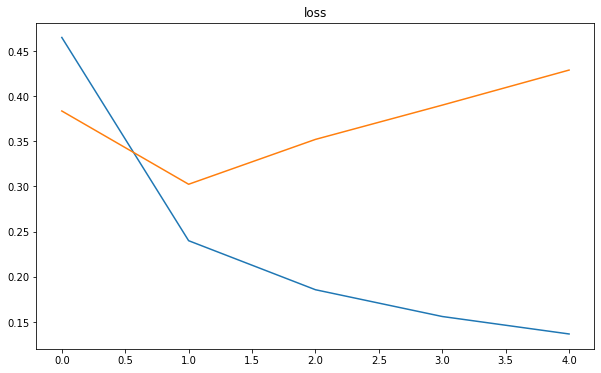

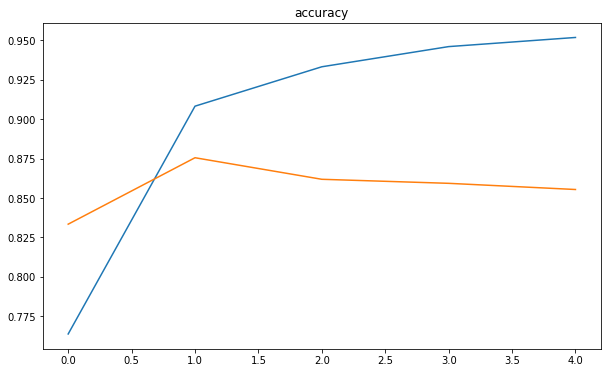

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

**Insert the discussion here**:

**Performances**

I tried to vary the parameters performing a kind of manual grid search, keeping the values in a reasonable range, in the specific I searched the embedded size of the tokens in the values [8, 16, 32, 128, 512], the number of heads in [1, 2, 4, 8, 16, 32] and the dimension of the feedforward network in the hidden layer in [64, 128, 512, 1024, 2048].

The best performances I obtained are the followings:

- embed_dim = 8, num_head = 1, ff_dim = 128: **86.27 %**

- embed_dim = 8, num_head = 2, ff_dim = 64: **86.03 %**

- embed_dim = 16, num_head = 4, ff_dim = 2048: **85.94 %**

- embed_dim = 16, num_head = 32, ff_dim = 1024: **85.91 %**

Obviously, the higher the parameter value for each of those ones, the higher is the training time, since in the first case, increasing the size of the embedding will cause more matricial computations in the attention matrix, instead highering the number of heads will increase more sequential operations, and finally raising the feedforward network neurons will grow the computation.

The final performaces are better than the SimpleRNN and gatedRNN ones, but worse than the bidirectional network. The latter indeed uses more parameters and has an higher maximum length. I also guess that transformers are more specific for translation and transduction problems rather than binary classification. 









